In [1]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

- Data Tranformation

In [3]:
# Rename columns for integration
# Load twitter dataset
twitter_df = pd.read_csv("Datasets/merged_datasetA(labeled).csv")

# Drop not necessory column
twitter_df.drop(columns=['score'], inplace=True)

# Rename columns
twitter_df.rename(columns={
    'preprocessed_text': 'preprocessed_news',
    'text': 'news'
}, inplace=True)

print("Updated columns:", twitter_df.columns)

Updated columns: Index(['preprocessed_news', 'news', 'sentiment'], dtype='object')


In [4]:
# Load news Dataset
news_df = pd.read_csv("Datasets/news_cleaned_trans(2018-2024).csv")

# Merge both dataset
combinedD_df = pd.concat([news_df, twitter_df], ignore_index=True)

# Save the merged dataset 
combinedD_df.to_csv("Datasets\\news_twitt_integrated.csv", index=False)

# Display first few rows 
print(combinedD_df.head())
print(len(combinedD_df))

                                                news  \
0  Readers point to Congress, the Federal Railroa...   
1  The president of the Association of American U...   
2  Readers discuss family estrangement from the p...   
3  He proposed talks with South Korea to discuss ...   
4  It was an oddly quiet end to a season of debat...   

                                   preprocessed_news sentiment  
0  readers point to congress they federal railroa...  Positive  
1  they president of they association of american...  Positive  
2  readers discuss family estrangement from they ...  Positive  
3  he proposed talks with south korea to discuss ...  Positive  
4  it was an oddly quiet end to a season of debat...  Positive  
281758


In [5]:
# Load news Dataset
finnews_df = pd.read_csv("Datasets/news_cleaned_trans_fin(2018-2024).csv")

# Merge both dataset
combinedDF_df = pd.concat([finnews_df, twitter_df], ignore_index=True)

# Save the merged dataset 
combinedDF_df.to_csv("Datasets\\news_twitt_integrated_fin.csv", index=False)

# Display first few rows 
print(combinedDF_df.head())
print(len(combinedDF_df))

                                                news  \
0  Readers point to Congress, the Federal Railroa...   
1  The president of the Association of American U...   
2  Readers discuss family estrangement from the p...   
3  He proposed talks with South Korea to discuss ...   
4  It was an oddly quiet end to a season of debat...   

                                   preprocessed_news sentiment  
0  Readers point to Congress the Federal Railroad...  Positive  
1  The president of the Association of American U...  Positive  
2  Readers discuss family estrangement from the p...  Positive  
3  He proposed talks with South Korea to discuss ...  Positive  
4  It was an oddly quiet end to a season of debat...  Positive  
281753


In [6]:
#Descriptive Analysis (AllCase)
def print_stats(stats_df, title):
    print(f"\n{title} Statistics:")
    print("="*50)
    print(stats_df.to_markdown(tablefmt="grid", stralign='center', numalign='center'))
    print("="*50)


combinedD_df["length"] = combinedD_df["news"].apply(lambda x: len(x.split()))
grouped_stats = combinedD_df.groupby('sentiment')["length"].agg(['max', 'min', 'mean', 'median', 'std', 'count'])
print_stats(grouped_stats, "Text Length per Label")


Text Length per Label Statistics:
+-------------+-------+-------+---------+----------+---------+---------+
|  sentiment  |  max  |  min  |  mean   |  median  |   std   |  count  |
+=============+=======+=======+=========+==========+=========+=========+
|  Negative   |  220  |   2   | 22.0575 |    22    | 7.10095 |  90699  |
+-------------+-------+-------+---------+----------+---------+---------+
|   Neutral   |  74   |   2   | 18.9041 |    17    | 8.43173 |  16406  |
+-------------+-------+-------+---------+----------+---------+---------+
|  Positive   |  175  |   1   | 19.8262 |    20    | 7.32224 | 174653  |
+-------------+-------+-------+---------+----------+---------+---------+


In [7]:
#Descriptive Analysis (Finbert)
def print_stats(stats_df, title):
    print(f"\n{title} Statistics:")
    print("="*50)
    print(stats_df.to_markdown(tablefmt="grid", stralign='center', numalign='center'))
    print("="*50)


combinedDF_df["length"] = combinedDF_df["news"].apply(lambda x: len(x.split()))
grouped_stats = combinedDF_df.groupby('sentiment')["length"].agg(['max', 'min', 'mean', 'median', 'std', 'count'])
print_stats(grouped_stats, "Text Length per Label")


Text Length per Label Statistics:
+-------------+-------+-------+---------+----------+---------+---------+
|  sentiment  |  max  |  min  |  mean   |  median  |   std   |  count  |
+=============+=======+=======+=========+==========+=========+=========+
|  Negative   |  220  |   2   | 22.0556 |    22    | 7.10234 |  90711  |
+-------------+-------+-------+---------+----------+---------+---------+
|   Neutral   |  74   |   2   | 18.9041 |    17    | 8.43173 |  16406  |
+-------------+-------+-------+---------+----------+---------+---------+
|  Positive   |  175  |   1   | 19.8278 |    20    | 7.32106 | 174636  |
+-------------+-------+-------+---------+----------+---------+---------+


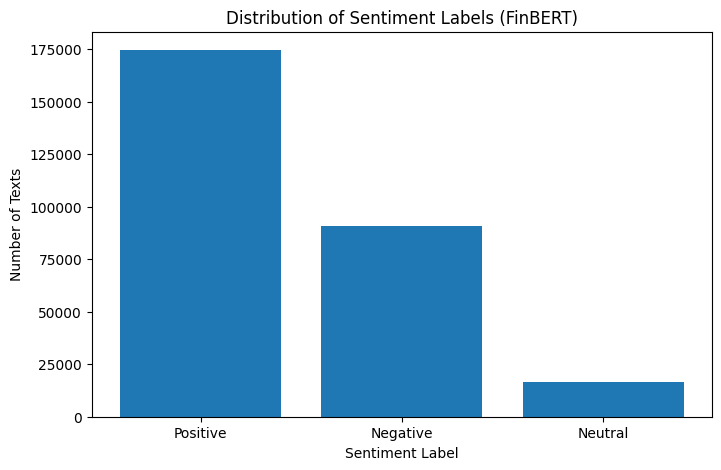

In [9]:
import matplotlib.pyplot as plt

# Count each sentiment label
sentiment_counts = combinedD_df['sentiment'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Texts")
plt.title("Distribution of Sentiment Labels (FinBERT)")
plt.show()


In [ ]:
# For FinBERT Dataset
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}
combinedDF_df["label_id"] = combinedDF_df["sentiment"].map(label2id)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(label2id.values())),
    y=combinedDF_df["label_id"]
)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print("Class Weights:", class_weights_tensor)

Class Weights: tensor([1.0354, 5.7246, 0.5378])


##### **Balance after split**

##### **FinBERT**

In [21]:

# 1. Load dataset (make sure your CSV has 'text' and 'label' columns)
finbalance_df = pd.read_csv("Datasets\\news_twitt_integrated_fin.csv")  # e.g., columns: text,label

# Convert labels to numeric if needed
# Example: 'positive' -> 2, 'neutral' -> 1, 'negative' -> 0
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
finbalance_df['sentiment'] = finbalance_df['sentiment'].map(label_map)

In [22]:
# 2. Split into train/test
train_df, test_df = train_test_split(finbalance_df, test_size=0.2, random_state=42, stratify=finbalance_df['sentiment'])

train_df = train_df.rename(columns={'sentiment': 'label'})
test_df = test_df.rename(columns={'sentiment': 'label'})

train_df.to_csv("Datasets/train_finbert_raw.csv", index=False)
test_df.to_csv("Datasets/test_finbert_raw.csv", index=False)

print("✅ Saved:")
print(" - Train (raw): train_finbert_raw.csv")
print(" - Test (raw): test_finbert_raw.csv")

✅ Saved:
 - Train (raw): train_finbert_raw.csv
 - Test (raw): test_finbert_raw.csv


##### **RandomOverSampling**

In [23]:
print("Before Resampling:")
print(train_df['label'].value_counts())

ros = RandomOverSampler(random_state=42)

# Apply oversampling only to train
X_resampled, y_resampled = ros.fit_resample(
    train_df[['preprocessed_news']],  
    train_df['label']
)

train_balanced_df = pd.DataFrame(X_resampled)
train_balanced_df['label'] = y_resampled

print("\nAfter ROS:")
print(train_balanced_df['label'].value_counts())

# Save balanced train set
train_balanced_df.to_csv("Datasets/train_finbert_balanced(ros).csv", index=False)

print("✅ Balanced train set saved: train_finbert_balanced(ros).csv")

Before Resampling:
label
2    139708
0     72569
1     13125
Name: count, dtype: int64

After ROS:
label
2    139708
0    139708
1    139708
Name: count, dtype: int64
✅ Balanced train set saved: train_finbert_balanced(ros).csv


##### **RandomUnderSampling**

In [24]:
print("Before Resampling:")
print(train_df['label'].value_counts())

rus = RandomUnderSampler(random_state=42)

# Apply oversampling only to train
X_resampled, y_resampled = rus.fit_resample(
    train_df[['preprocessed_news']],  
    train_df['label']
)

train_balanced_df = pd.DataFrame(X_resampled)
train_balanced_df['label'] = y_resampled

print("\nAfter RUS:")
print(train_balanced_df['label'].value_counts())

# Save balanced train set
train_balanced_df.to_csv("Datasets/train_finbert_balanced(rus).csv", index=False)

print("✅ Balanced train set saved: train_finbert_balanced(rus).csv")

Before Resampling:
label
2    139708
0     72569
1     13125
Name: count, dtype: int64

After RUS:
label
0    13125
1    13125
2    13125
Name: count, dtype: int64
✅ Balanced train set saved: train_finbert_balanced(rus).csv


##### **For Other Classification Model**

In [25]:

# 1. Load dataset (make sure your CSV has 'text' and 'label' columns)
allcasebalance_df = pd.read_csv("Datasets\\news_twitt_integrated.csv")  # e.g., columns: text,label

# Convert labels to numeric if needed
# Example: 'positive' -> 2, 'neutral' -> 1, 'negative' -> 0
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
allcasebalance_df['sentiment'] = allcasebalance_df['sentiment'].map(label_map)

In [26]:
# 2. Split into train/test
trainAC_df, testAC_df = train_test_split(allcasebalance_df, test_size=0.2, random_state=42, stratify=allcasebalance_df['sentiment'])

trainAC_df = trainAC_df.rename(columns={'sentiment': 'label'})
testAC_df = testAC_df.rename(columns={'sentiment': 'label'})

trainAC_df.to_csv("Datasets/train_allcase_raw.csv", index=False)
testAC_df.to_csv("Datasets/test_allcase_raw.csv", index=False)

print("✅ Saved:")
print(" - Train (raw): train_allcase_raw.csv")
print(" - Test (raw): test_allcase_raw.csv")

✅ Saved:
 - Train (raw): train_allcase_raw.csv
 - Test (raw): test_allcase_raw.csv


##### **RandomOverSampling**

In [27]:
print("Before Resampling:")
print(trainAC_df['label'].value_counts())

ros = RandomOverSampler(random_state=42)

# Apply oversampling only to train
X_resampled, y_resampled = ros.fit_resample(
    trainAC_df[['preprocessed_news']],  
    trainAC_df['label']
)

trainAC_balanced_df = pd.DataFrame(X_resampled)
trainAC_balanced_df['label'] = y_resampled

print("\nAfter ROS:")
print(trainAC_balanced_df['label'].value_counts())

# Save balanced train set
trainAC_balanced_df.to_csv("Datasets/train_allcase_balanced(ros).csv", index=False)

print("✅ Balanced train set saved: train_allcase_balanced(ros).csv")

Before Resampling:
label
2    139722
0     72559
1     13125
Name: count, dtype: int64

After ROS:
label
0    139722
2    139722
1    139722
Name: count, dtype: int64
✅ Balanced train set saved: train_allcase_balanced(ros).csv


##### **RandomUnderSampling**

In [28]:
print("Before Resampling:")
print(trainAC_df['label'].value_counts())

rus = RandomUnderSampler(random_state=42)

# Apply oversampling only to train
X_resampled, y_resampled = rus.fit_resample(
    trainAC_df[['preprocessed_news']],  
    trainAC_df['label']
)

trainAC_balanced_df = pd.DataFrame(X_resampled)
trainAC_balanced_df['label'] = y_resampled

print("\nAfter RUS:")
print(trainAC_balanced_df['label'].value_counts())

# Save balanced train set
trainAC_balanced_df.to_csv("Datasets/train_allcase_balanced(rus).csv", index=False)

print("✅ Balanced train set saved: train_allcase_balanced(rus).csv")

Before Resampling:
label
2    139722
0     72559
1     13125
Name: count, dtype: int64

After RUS:
label
0    13125
1    13125
2    13125
Name: count, dtype: int64
✅ Balanced train set saved: train_allcase_balanced(rus).csv


##### **Back Translation and Synonym Replacement**

##### **Google Trnslator**

In [ ]:
from deep_translator import GoogleTranslator
import pandas as pd
from tqdm import tqdm
import time

gt_df = pd.read_csv("Datasets\\news_twitt_integrated_fin.csv")

back_translation_lang = 'fr'

def back_translate(text, intermediate_lang='fr'):
    try:
        translated = GoogleTranslator(source='en', target=intermediate_lang).translate(text)
        time.sleep(0.5)  

        back_translated = GoogleTranslator(source=intermediate_lang, target='en').translate(translated)
        time.sleep(0.5)
        return back_translated
    except Exception as e:
        print(f"Translation error: {e}")
        return text  

tqdm.pandas()
gt_df['back_translated'] = gt_df['preprocessed_news'].progress_apply(lambda x: back_translate(x, back_translation_lang))

print("\n✅ Back Translation Complete!")
print(gt_df[['preprocessed_news', 'back_translated', 'sentiment']])


  0%|          | 17/281753 [00:51<235:47:02,  3.01s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import torch
import random

btsr_df = pd.read_csv("Datasets\\news_twitt_integrated_fin.csv")

SRC_LANG = "en"
MID_LANG = "fr"   # You can switch to 'de', 'es', 'zh', etc.

en_to_fr_model_name = f"Helsinki-NLP/opus-mt-{SRC_LANG}-{MID_LANG}"
fr_to_en_model_name = f"Helsinki-NLP/opus-mt-{MID_LANG}-{SRC_LANG}"

print("Loading EN→FR model...")
en_to_fr_tokenizer = MarianTokenizer.from_pretrained(en_to_fr_model_name)
en_to_fr_model = MarianMTModel.from_pretrained(en_to_fr_model_name)

print("Loading FR→EN model...")
fr_to_en_tokenizer = MarianTokenizer.from_pretrained(fr_to_en_model_name)
fr_to_en_model = MarianMTModel.from_pretrained(fr_to_en_model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
en_to_fr_model.to(device)
fr_to_en_model.to(device)
print("EN→FR model device:", next(en_to_fr_model.parameters()).device)
print("FR→EN model device:", next(fr_to_en_model.parameters()).device)

def translate_text(texts, tokenizer, model, max_length=512, batch_size=8, desc="Translating"):
    translated = []
    for i in tqdm(range(0, len(texts), batch_size), desc=desc, ncols=100):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            generated = model.generate(**encoded)
        out_texts = tokenizer.batch_decode(generated, skip_special_tokens=True)
        translated.extend(out_texts)
    return translated

label_counts = btsr_df['sentiment'].value_counts()
max_count = label_counts.max()

print("\n=== Current Label Distribution ===")
print(label_counts)

augmentation_plan = {}
for label, count in label_counts.items():
    if count < max_count:
        needed = max_count - count
        augmentation_plan[label] = needed

print("\n=== Augmentation Plan (Samples to Generate) ===")
for label, needed in augmentation_plan.items():
    print(f"Label: {label:10} | Needed: {needed}")

augmented_rows = []

for label, needed_samples in augmentation_plan.items():
    subset = btsr_df[btsr_df['sentiment'] == label]

    sampled_texts = subset['preprocessed_news'].sample(
        n=needed_samples,
        replace=True,
        random_state=42
    ).tolist()

    print(f"\n🔁 Back translating {needed_samples} samples for label: {label}")

    mid_texts = translate_text(
        sampled_texts,
        en_to_fr_tokenizer,
        en_to_fr_model,
        desc=f"EN→{MID_LANG.upper()} ({label})"
    )

    back_translated = translate_text(
        mid_texts,
        fr_to_en_tokenizer,
        fr_to_en_model,
        desc=f"{MID_LANG.upper()}→EN ({label})"
    )

    augmented_rows.extend([
        {'preprocessed_news': bt, 'sentiment': label} for bt in back_translated
    ])


aug_df = pd.DataFrame(augmented_rows)
final_df = pd.concat([btsr_df, aug_df], ignore_index=True)

# Check new label distribution
print("\n=== New Label Distribution (After Augmentation) ===")
print(final_df['sentiment'].value_counts())


final_df.to_csv("Datasets\\news_twitt_integrated_fin(BTSR).csv", index=False)
print("\n✅ Balanced dataset saved as 'news_twitt_integrated_fin(BTSR).csv'")


c:\Python_Env\fyp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading EN→FR model...


c:\Python_Env\fyp_env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Loading FR→EN model...
EN→FR model device: cuda:0
FR→EN model device: cuda:0

=== Current Label Distribution ===
sentiment
Positive    174636
Negative     90711
Neutral      16406
Name: count, dtype: int64

=== Augmentation Plan (Samples to Generate) ===
Label: Negative   | Needed: 83925
Label: Neutral    | Needed: 158230

🔁 Back translating 83925 samples for label: Negative


EN→FR (Negative):   8%|███                                    | 822/10491 [09:06<1:47:13,  1.50it/s]


KeyboardInterrupt: 